# Ctrl-VQE with Julia: Proof of Concept
Welcome!

This file is meant to guide you through a sample ctrl-VQE calculation,
    using my Julia implementation.

The present version is somewhat transitory - it's not even a real package yet.
But since the code as of writing is *capable* of running ctrl-VQE
    (and much more efficiently than ctrlq) I wanted to get this version out
    to those of you doing *real* science (not just glorified software development ^_^).

This notebook consists of Julia cells,
    each followed by annotation in Markdown,
    explaining the philosophy behind the code.
I dare to think that working through this notebook
    would be a decent introduction to Julia itself,
    so do take the time to read all the annotations!

## PRELIMINARY SETUP
The first thing to do is some generic Julia stuff, imports and such.

In [232]:
# `using` STATEMENTS
using Random, LinearAlgebra         # STANDARD LIBRARIES
using Plots, LBFGSB                 # NEED TO BE INSTALLED

The `using` keyword adds all of the (exported) names (ie. variables and methods)
    in the given package to the current namespace.

I don't actually like using it because it makes tracing code significantly harder,
    so that my own code doesn't actually "export" anything at all.
But we'll go ahead and use `using` for the standard libraries in this script,
    since that seems to be the Julia style.

In [233]:
# `include` STATEMENTS
include("../src/utils.jl");
include("../src/device.jl");
include("../src/pulse.jl");
include("../src/evolve.jl");
include("../src/gradient.jl");

`include` is not quite the same as `import`.
We'll actually have to import the contents of these files next.

`include` is like copying the given source file directly into this script.
It *shouldn't* be necessary,
    because I *should* be packaging my source code into packages.
But I haven't gotten around to learning how to do that yet,
    so this is how it works for now. ^_^

In [234]:
# `import` STATEMENTS
import ..Utils, ..Devices, ..Pulses, ..Evolutions, ..Gradients      # CORE MODULES

`import` adds the given package name itself into the current namespace.
            We can access the package's members via dot notation (eg. `Utils.on`).

The `..` preceding each package name is a little idiosyncracy due to the fact
    that these aren't actually packages (see `include` notes), but modules.
That should be changed sometime, uh, soon-ish.

## CHEMISTRY SETUP
Now let's define the problem. What system are we trying to solve?

In [235]:
# LOAD THE HAMILTONIAN FROM AN `.npy` FILE
using NPZ
H = npzread("../matrix/lih30.npy")   # THE MATRIX REPRESENTING THE MOLECULAR HAMILTONIAN
n = round(Int, log2(size(H,1)))     # THE NUMBER OF QUBITS WE'LL NEED

4

There is *some* code to interface with pyscf and generate `H` directly,
    but it's not thorough and it can be a bit of a pain.
So, in this notebook, we have elsewhere generated the molecular Hamiltonian,
    and we are simply loading it here.

In [236]:
# INITIAL KET |1…10…0⟩
init_ket = "1"^(n÷2) * "0"^(n÷2)

#= NOTE: Half-and-half works for H2 and LiH, but doesn't always! =#

"1100"

Later on, we'll initialize a statevector `|ψ0⟩` so that
    `⟨z|ψ0⟩=1` if `|z⟩` is `|init_ket⟩`, and `⟨z|ψ0⟩=0` otherwise.

Each character represents the occupation of a spin-orbital.
Odd-indexed characters correspond to α spin; even-indexed to β spin.
    (NOTE: Does that sound backwards? Julia indexes from 1, not 0!)

The usual thing is to set `|init_ket⟩` to the Hartree Fock state,
    which fills up orbitals from the left with available electrons.
For example, in a singlet system, there are as many α-electrons as β-electrons,
    so the Hartree-Fock ket is just as many 1's as there are electrons,
    followed by as many 0's as needed to address the remaining spin-orbitals.

## PROBLEM SPECS
Here we'll define a bunch of variables that will be used throughout.

In [237]:
# THE NUMBER OF MODES CONSIDERED FOR EACH TRANSMON
m = 2

2

Note the distinction:
    In a digital quantum computation, every qubit has two levels,
        and it's easy(ish) to map each qubit to the fermionic electron problem.
    But in ctrl-VQE, we are closer to hardware:
        we are forced to treat qubits as *bosonic* systems,
        with an infinite-dimensional Hilbert space.
    We have to truncate at some point: this is `m`.

Note if our pulses never ever produce any leakage
        into modes outside the computational space (ie. 0 and 1 on each transmon),
        `m=2` is sufficient, and easiest to simulate.
BUT there could be some benefit to intentionally inducing leakage;
    that's one of our lines of research!

In [238]:
# PHYSICAL CHARACTERISTICS OF OUR DEVICE
device = Devices.selectqubits(1:n, Devices.Transmon(
    2π*[3.7, 4.2, 3.5, 4.0],                    # QUBIT RESONANCE FREQUENCIES
    2π*[0.3, 0.3, 0.3, 0.3],                    # QUBIT ANHARMONICITIES
    Dict{Devices.QubitCouple,Float64}(          # QUBIT COUPLING CONSTANTS
        Devices.QubitCouple(1,2) => 2π*.018,
        Devices.QubitCouple(2,3) => 2π*.021,
        Devices.QubitCouple(3,4) => 2π*.020,
        Devices.QubitCouple(1,3) => 2π*.021,
        Devices.QubitCouple(2,4) => 2π*.020,
        Devices.QubitCouple(1,4) => 2π*.021,
    )
))

Main.Devices.Transmon(4, [23.24778563656447, 26.389378290154262, 21.991148575128552, 25.132741228718345], [1.8849555921538759, 1.8849555921538759, 1.8849555921538759, 1.8849555921538759], Dict{Main.Devices.QubitCouple, Float64}(Main.Devices.QubitCouple(3, 4) => 0.12566370614359174, Main.Devices.QubitCouple(1, 2) => 0.11309733552923254, Main.Devices.QubitCouple(1, 4) => 0.13194689145077132, Main.Devices.QubitCouple(2, 4) => 0.12566370614359174, Main.Devices.QubitCouple(2, 3) => 0.13194689145077132, Main.Devices.QubitCouple(1, 3) => 0.13194689145077132))

There are a whole bunch of things to note here:
1. The numbers in the example are utterly arbitrary.
   Orders of magnitude are (probably) consistent with IBMQ devices,
    but the numbers were haphazardly generated at whim.
   You should absolutely change them to something sensible. ^_^

   (1b) I inherited the convention of using units of 2π from ctrlq;
   I don't really understand why I'm doing it... ^_^

2. The example is a device with four qubits.
   If your calculation needs more qubits,
    just add on to the frequency and anharmonicity vectors accordingly,
    and add qubit couplings as you deem appropriate.
   If your calculation needs fewer qubits,
    the call to `selectqubits` takes care of it.

3. The qubit coupling constants are assumed to be symmetric.
   Thus, you could specify the pairing between qubits 1 and 2 with EITHER of
    `Devices.QubitCouple(1,2)`  OR  `Devices.QubitCouple(2,1)`
   They are the same object.

4. Julia indexes from 1, not from 0.
   For example, `Devices.QubitCouple(1,2)` indicates the pairing between
    the *first and second* qubits.

In [239]:
# NUMBER OF TIME STEPS
r = 1000

1000

In the ctrlq code, a typical number of time steps was on the order of 1000.
This code has made some numerical improvements,
    so the same results should be obtainable with a fraction of that.

But if something isn't working the way you expect,
    it's not a bad idea to bump this up a couple orders of magnitude
    and see if that fixes it...

In [240]:
# PULSE CONSTRAINTS
ΔΩ = 2π * 0.02      # RANGE OF PULSE AMPLITUDE
ΔΔ = 2π * 0.10      # RANGE OF DE-TUNING

0.6283185307179586

Pulse amplitude `Ω` on each qubit will be constrained to `Ω ∈ (-ΔΩ, +ΔΩ)`.

Pulse frequency `ν` on qubit with resonance `ω` will be constrained to `ν ∈ (ω-ΔΔ, ω+ΔΔ)`.
I don't know if constraining frequency like this makes sense in experiment,
    but since the pulse gets less and less *relevant* as `Δ≡ω-ν` gets larger,
    it makes sense in theory.

In [241]:
# PULSE HYPER-PARAMETERS
T = 40.0        # TOTAL PULSE DURATION
W = 100          # NUMBER OF PULSE WINDOWS
steptimes = repeat( range(0,T,W+1)[2:end-1], 1, n)      # PULSE WINDOW STEP TIMES

99×4 Matrix{Float64}:
  0.15   0.15   0.15   0.15
  0.3    0.3    0.3    0.3
  0.45   0.45   0.45   0.45
  0.6    0.6    0.6    0.6
  0.75   0.75   0.75   0.75
  0.9    0.9    0.9    0.9
  1.05   1.05   1.05   1.05
  1.2    1.2    1.2    1.2
  1.35   1.35   1.35   1.35
  1.5    1.5    1.5    1.5
  ⋮                   
 13.65  13.65  13.65  13.65
 13.8   13.8   13.8   13.8
 13.95  13.95  13.95  13.95
 14.1   14.1   14.1   14.1
 14.25  14.25  14.25  14.25
 14.4   14.4   14.4   14.4
 14.55  14.55  14.55  14.55
 14.7   14.7   14.7   14.7
 14.85  14.85  14.85  14.85

You'll likely want to change these,
    or write your own script to change them adaptively.
    This is just a proof-of-concept, after all!

The step times are an n-column matrix setting each window to be equally spaced.
    You could instead manually set it, or write your own adaptive strategy.

## MORE SETUP!
Now we're going to derive a bunch of things, from the parameters given above.
You shouldn't need to change anything here,
    but study the notes so you know what's going on!

In [242]:
# TOTAL SIZE OF HIBLERT SPACE BEING SIMULATED
N = m^n

16

Note that this is generally larger than the 2^n Hilbert space being "solved".

In [243]:
# SINGLE-QUBIT BOSONIC ANNIHILATION OPERATOR (truncated to m modes)
a = Utils.a_matrix(m)

2×2 Matrix{Float64}:
 0.0  1.0
 0.0  0.0

In [244]:
# EXTEND OBSERVABLE ONTO SIMULATION SPACE
Π = Utils.projector(n, 2, m)    # PROJECTOR FROM SIMULATION SPACE ONTO PROBLEM SPACE
O = Hermitian(Π'*H*Π)           # MOLECULAR HAMILTONIAN, EMBEDDED INTO SIMULATION SPACE

16×16 Hermitian{ComplexF64, Matrix{ComplexF64}}:
    -7.52758+0.0im         0.0+0.0im  …  -0.0518537+0.0im     0.121594+0.0im
         0.0-0.0im    -7.22541+0.0im            0.0+0.0im          0.0+0.0im
  0.00805343-0.0im         0.0-0.0im     -0.0877143+0.0im   -0.0733995+0.0im
 -5.93215e-9-0.0im         0.0-0.0im     -0.0733995+0.0im  -5.93215e-9+0.0im
   0.0425392-0.0im         0.0-0.0im      0.0582494+0.0im   -0.0518537+0.0im
         0.0-0.0im  -0.0323405-0.0im  …         0.0+0.0im          0.0+0.0im
   0.0499849-0.0im         0.0-0.0im       0.120731+0.0im    0.0499849+0.0im
  -0.0733995-0.0im         0.0-0.0im      0.0499849+0.0im   0.00805343+0.0im
         0.0-0.0im         0.0-0.0im            0.0+0.0im          0.0+0.0im
         0.0-0.0im         0.0-0.0im            0.0+0.0im          0.0+0.0im
         0.0-0.0im         0.0-0.0im  …         0.0+0.0im          0.0+0.0im
         0.0-0.0im         0.0-0.0im            0.0+0.0im          0.0+0.0im
  -0.0555554-0.0im         

Nick tells me that Π is really an "isometry", and the projector is Π'Π.
Names will likely change in a future version.

The `Hermitian` command just wraps the matrix Π'HΠ into a "Hermitian" matrix object,
    so that Julia knows it can use more efficient algorithms on it.

In [245]:
# PREPARE THE HARTREE-FOCK STATE
ψ0 = zeros(ComplexF64, N)                               # INITIALIZE ⟨z|ψ0⟩ = 0
ψ0[1 + parse(Int, init_ket, base=m)] = one(ComplexF64)  # SET ⟨init_ket|ψ0⟩ = 1

1.0 + 0.0im

Here we are using the `init_ket` string in the chemistry section,
    to initialize the corresponding statevector in the simulation space.

The `parse(Int, init_ket, base=m)` interprets the `init_ket` string
    as an integer represented with base-`m` digits.
We have to add `1 +` because Julia starts indexing from 1,
    so for example `|000⟩` is actually index 1.

In [246]:
# SET OPTIONS FOR DIFFERENT CALCULATION MODES
qubitapplymode = Evolutions.Kronec()    # HOW TO APPLY SINGLE-QUBIT OPERATORS?
iobasis = Evolutions.QubitBasis()       # HOW TO INTERPRET THE INPUT/OUTPUT STATEVECTOR?

Main.Evolutions.QubitBasis()

##### `qubitapplymode`
`qubitapplymode` could be `Evolutions.Kronec()` or `Evolutions.Tensor()`

In principle, `Tensor` mode is faster,
    but there's such significant overhead that up to ~5 qubits
    you probably want to stick with `Kronec`.

In truth, single-qubit operations aren't the "rate-limiting step", so to speak,
    so when in doubt, stick with `Kronec`. ;)

NOTE: The new version under development will do away with the overhead on `Tensor`,
    and therefore render `qubitapplymode` redundant.

##### `iobasis`
`iobasis` could be `Evolutions.QubitBasis()` or `Evolutions.DeviceBasis()`

We're not entirely sure yet which one more closely matches a real experiment.

It (no longer) makes any computational difference,
    so I've picked `QubitBasis` because I find it more intuitive.

In [247]:
# DISCRETIZE TIME
t_= range(0,T,r+1)                 # TIME GRID
τ = T / r                          # DURATION OF EACH TIME STEP

0.015

I like to use an underscore suffix to represent an array.
    So, `t` is a single time point, and `t_` is an array of time points.

Note that `τ == t_[2]-t[1]`, and there are a total of `r` "steps" in `t_`.

NOTE: My preference has changed since writing this code.
Instead of putting the line AFTER the variable,
    I've been putting the line ABOVE the variable (ie. `t̄`)
    because Julia editors let you do that easily.
But for this notebook, we'll stick to my old Python habits. ;)

In [248]:
# HEAVY CALCULATIONS FOR WORKING IN THE DEVICE BASIS (aka "dressed basis")
HD = Devices.static_hamiltonian(device, m)  # DEVICE HAMILTONIAN
ΛD, UD = Utils.dressedbasis(HD)             # DEVICE EIGENVALUES AND EIGENVECTORS
L = UD* Diagonal(exp.((-im*τ) * ΛD)) *UD'   # REPEATED DEVICE ACTION FOR EACH TIME STEP

16×16 Matrix{ComplexF64}:
 1.0+0.0im           0.0+0.0im          …       0.0+0.0im
 0.0+0.0im      0.929771-0.368123im             0.0+0.0im
 0.0+0.0im  -0.000655931-0.00176693im           0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im  -0.000713675-0.00174465im           0.0+0.0im
 0.0+0.0im           0.0+0.0im          …       0.0+0.0im
 0.0+0.0im   4.21664e-17-1.53295e-17im          0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im  -0.000705719-0.00184904im           0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im  -2.86548e-17+1.04174e-17im  …       0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im           0.0+0.0im          …  0.119097-0.992883im

The method `Utils.dressedbasis` is essentially just factoring `H → UΛU'`,
    but there are a couple extra steps, like changing the ordering of eigenvectors.

The letter `L` stands for "ligand", because `L` is the "ligand operator"
    connecting the application of the drive Hamiltonian at each time step.

In [249]:
# PRE-ALLOCATIONS
ψ  = Vector{ComplexF64}(undef, m^n)         # FOR STORING THE WAVEFUNCTION
∇Ω = Matrix{Float64}(undef, r+1, n)         # FOR STORING THE DERIVATIVES

_N1 = Vector{ComplexF64}(undef, N)          # FOR MATRIX-VECTOR MULTIPLICATION
_m2_ = [Matrix{ComplexF64}(undef, m,m) for q ∈ 1:n]     # QUBIT-WISE DRIVE OPERATORS
_K_ = [Matrix{ComplexF64}(undef, m^q, m^q) for q ∈ 1:n] # FOR KRON'ing OPERATORS

4-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]
 [2.9726972925e-314 + 2.9726973636e-314im 2.9726978617e-314 + 2.9726978854e-314im 2.9726980514e-314 + 2.972698075e-314im 2.972698241e-314 + 2.9726982885e-314im; 2.972697435e-314 + 2.972697506e-314im 2.972697909e-314 + 2.972697933e-314im 2.972698099e-314 + 2.9726981225e-314im 2.972698312e-314 + 2.972698336e-314im; 2.972697577e-314 + 2.972697648e-314im 2.9726979565e-314 + 2.97269798e-314im 2.972698146e-314 + 2.97269817e-314im 2.9726983597e-314 + 2.9726983834e-314im; 2.9726977194e-314 + 2.9726977905e-314im 2.972698004e-314 + 2.9726980277e-314im 2.9726981937e-314 + 2.9726982174e-314im 2.972698407e-314 + 2.9726984545e-314im]
 [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 2.586563270614692e-231 + 2.0316e-320im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 2.5764989750623177e-231 + 1.33144834e-315im]
 [0.0 + 6.36

`ψ` and `∇Ω` are the variables to which the important calculations will be written.

The rest are just "junk".
To minimize the computational effort at each time-step,
    the evolve and gradient functions let you pass "pre-allocated" blocks of memory
    that they can use as "work" variables, to store intermediate results in.

I'm prefixing these with an underscore, to flag them as "meaningless to inspect".
The names represent their use:
    `_N1` is a 1d vector of `N` elements.
    `_m2_` is an *array* of `m×m` matrices.
    `_K_` is the most niche; it's an array of matrices of increasing size.
        Each one is used to store an intermediate result in the
            (K)ronecker products of many single-qubit operators.

In [250]:
# WRAP ALL THESE UP INTO A NICE, TIDY KEYWORD DICTIONARY
evolve_kwargs = Dict(
    :iobasis => iobasis, :qubitapplymode => qubitapplymode, :numsteps => r,
    :N => N, :n => n, :m => m, :T => T, :t_=> t_, :Δt=> τ,
    :ΛD => ΛD, :UD => UD, :V  => L, :a  => a,
    :tmpV  => _N1, :tmpM_ => _m2_, :tmpK_ => _K_,
)

gradient_kwargs = Dict(
    :iobasis => iobasis, :qubitapplymode => qubitapplymode, :r => r,
    :N => N, :n => n, :m => m, :T => T, :t_=> t_, :τ => τ,
    :ΛD => ΛD, :UD => UD, :V  => L, :a  => a,
    :tmpV  => _N1, :tmpM_ => _m2_, :tmpK_ => _K_, :∂Ω => ∇Ω,
)


Dict{Symbol, Any} with 17 entries:
  :UD             => [1.0 0.0 … 0.0 0.0; 0.0 0.991164 … 0.0 0.0; … ; 0.0 0.0 … …
  :n              => 4
  :V              => ComplexF64[1.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+…
  :ΛD             => [0.0, 25.1324, 21.9705, 47.1013, 26.4119, 51.5464, 48.3783…
  :qubitapplymode => Kronec()
  :tmpV           => ComplexF64[3.5e-323+4.4e-323im, 1.93e-322+2.1e-322im, 2.17…
  :iobasis        => QubitBasis()
  :N              => 16
  :tmpK_          => Matrix{ComplexF64}[[0.0+0.0im -0.0+0.0im; 0.0+0.0im 0.0+0.…
  :r              => 1000
  :tmpM_          => Matrix{ComplexF64}[[1.0+0.0im 0.0+0.0im; 0.0-0.0im 1.0+0.0…
  :T              => 15.0
  :m              => 2
  :a              => [0.0 1.0; 0.0 0.0]
  :∂Ω             => [0.0 0.0 2.14414e-314 2.14406e-314; 6.93616e-310 0.0 2.144…
  :τ              => 0.015
  :t_             => 0.0:0.015:15.0

The evolve and gradient functions will re-compute a lot of this stuff automatically
    unless you provide pre-calculated values as keywork arguments.
But, providing all these keyword arguments makes the function calls look very ugly.
So I'm wrapping it all into a nice dictionary
    that can just be dereferenced in the function calls.

## DEFINE PULSE, COST FUNCTION, AND GRADIENT FUNCTION
My apologies - there is more happening in this section than I had intended.
I had meant for many of these things to be handled inside my core modules,
    but I realized that the way I want to handle them will require big changes,
and I want to get this tutorial out ASAP.

Therefore I'm implementing the details of working with a square pulse here,
    and including lots of notes so that you understand
    how to adapt it to any pulse shape you like. ^_^

In a later version, these things should all be bound up into a tidy module,
    which you can simply extend as you define new pulse shapes.

For this section, my annotations are given in "doc-strings" directly in the Julia cells.

In [251]:
"""
    constructpulse(x::AbstractVector{<:Real})

This function constructs a set of pulse objects for each qubit,
    out of a vector of optimizable parameters.

In this example, each pulse will be a sequence of `W` square pulses.

The vector `x` must specify:
- `W` different amplitudes A[j]
- a single ν, for the frequency of the pulse.

Actually, `x` must specify each of these for all `n` qubits,
    for a total of `n(W+1)` parameters.

"""
function constructpulses(x::AbstractVector{<:Real})
    x = reshape(x, :, n)    # RE-INTERPRET `x` AS `n` COLUMNS

    pulses = Vector{Pulses.BasicSquarePulse}(undef, n)
    for q in 1:n
        A = x[1:W,q]                # AMPLITUDE ARRAY
        ν = x[end,q]                # FREQUENCY
        pulses[q] = Pulses.BasicSquarePulse(T, ν, A, steptimes[:,q])
    end
    return pulses
end

constructpulses

In [252]:
"""
    pulsegradient_amplitude(t, j, pulse)

Consider the pulse amplitude Ω(t) on a single qubit.
    In our example, Ω(t) is a step function, determined by each A[j] and s[j].
    We're assuming s[j] are held constant in this tutorial,
        but a bit of calculus gives us the partial derivatives ∂Ω(t)/∂A[j].

This function gives ∂Ω(t)/∂A[j].

"""
function pulsegradient_amplitude(t, j, pulse)
    return Utils.interval(t,
        get(pulse.steptimes, j-1, 0),               #  LEFT BOUND (TREAT s[0] as t=0)
        get(pulse.steptimes, j, pulse.duration),    # RIGHT BOUND (TREAT s[W] as t=T)
    )
end

pulsegradient_amplitude

In [253]:
∂Ω∂x = Vector{Float64}(undef, r+1)  # PRE-ALLOCATE A VECTOR TO HOLD THESE GRADIENTS
h = 1e-6                # SPACING FOR A FINITE DIFFERENCE ON THE FREQUENCY PARAMETER

1.0e-6

In [254]:
"""
    f(x)

The cost function to be used in optimization.

Returns the energy ⟨ψ|O|ψ⟩, where |ψ⟩ is the quantum state prepared
    by applying the pulse sequences parameterized by `x` to the initial state |ψ0⟩.

Note that this energy is "unnormalized",
    meaning it will actually be implicitly a little higher
    than the one you'd get by ⟨ψ'|H|ψ'⟩, where |ψ'⟩ is |ψ⟩ retricted to 0's and 1's.
That means leakage into modes larger than 0 and 1 will be implicitly penalized
    in an optimization.

The true minimum of O will be exactly equal to the true minimum of H,
    but there's no guarantee an optimization *finds* the true minimum,
    so you must correct for leakage before interpreting the accuracy of your optimization:

    ⟨ψ'|H|ψ'⟩ = ⟨ψ|O|ψ⟩ / ⟨ψ|Π'Π|ψ⟩

"""
function f(x)
    pulses = constructpulses(x)
    ψ .= Evolutions.evolve(ψ0, pulses, device, Evolutions.Rotate; evolve_kwargs...)
    return real(Utils.expectation(O, ψ))
end

f

In [255]:
"""
    g!(G, x)

The gradient function to be used in optimization.

`G` is just a pre-allocated block of memory to write the gradient vector to.
The `!` in the name is just Julia convention to mark this function as one
    which mutates its primary operand (in this case, `G`).

To calculate the gradients ∂E/∂A[j],
    we'll need to do some rather unrigorous calculus:

    ∂E/∂x[j] = ∂E/∂Ω(t) · ∂Ω(t)/∂x[j]
                        ↑
            This is a vector dot product.

We've implemented ∂Ω(t)/∂x[j] at the start of this section.
The ∂E/∂Ω(t) is what we're calling the gradient signal, or switching function φ(t).

    (Actually my gradient signal has an extra `τ` (aka `dt`) in it,
        and I'm not exactly certain what it's doing there.
    But it seems to work... )

To calculate the gradients ∂E/∂ν...
    ah, well, there is a *frequency* gradient signal I could calculate.
But I haven't implemented that yet.
So what we're going to do instead is run a forward finite difference,
    on just these `n` parameters... ^_^

"""
function g!(G, x)
    G = reshape(G, :, n)    # RE-INTERPRET `G` AS `n` COLUMNS

    # CONSTRUCT THE AMPLITUDE GRADIENT SIGNAL ∇Ω ~= ∂E/∂Ω(t) dt
    pulses = constructpulses(x)
    Gradients.gradientsignal(ψ0, pulses, device, O; gradient_kwargs...)
        #= Because we put a pre-allocated `∇Ω` into `gradient_kwargs`,
            this method writes the gradient signal to that `∇Ω`. =#

    # EVALUATE THE COST FUNCTION AT x, FOR FORWARD FINITE DIFFERENCES
    f0 = f(x)

    for (q, pulse) in enumerate(pulses)
        for j in 1:W
            # SET THE GRADIENTS G[j] ~= ∂E/∂A[j]
            ∂Ω∂x .= map(t -> pulsegradient_amplitude(t,j,pulse), t_)
            G[j,q] = ∇Ω[:,q] · ∂Ω∂x
        end

        # SET THE GRADIENTS G[j] ~= ∂E/∂ν
        Δν = h * Utils.basisvector(length(x), (W+1)*q)
        G[W+1,q] = (f(x+Δν) - f0) / h
    end

end

g!

## RUN L-BFGS-B OPTIMIZATION
In this section, we'll set up our constraints and initial guess,
    and run the optimization.

The optimization package I'm using is a wrapper around C code, I think.

In [256]:
# CONFIGURE BOUNDS
lbounds = Matrix{Float64}(undef, W+1, n); ubounds = Matrix{Float64}(undef, W+1, n)
# # #
lbounds[1:W,:] .= -ΔΩ                       # SET MAXIMUM AMPLITUDE
ubounds[1:W,:] .=  ΔΩ
# # #
lbounds[end,:] .= device.ω .- ΔΔ            # SET FREQUENCY CONSTRAINTS
ubounds[end,:] .= device.ω .+ ΔΔ

4-element view(::Matrix{Float64}, 101, :) with eltype Float64:
 23.876104167282428
 27.01769682087222
 22.61946710584651
 25.761059759436304

In [257]:
# CONFIGURE INITIAL PARAMETERS
Random.seed!(0)                         # CHANGE SEED AT WILL!
x0 = Matrix{Float64}(undef, W+1, n)
# # #
x0[1:W,:] .= ΔΩ * (2*rand(W,n) .- 1)                        # RANDOMLY SELECTED AMPLITDUES
x0[end,:] .= ΔΔ * (2*rand(n) .- 1) .+ device.ω              # RANDOMLY SELECTED FREQUENCIES
x0 = vec(x0)                            # RESHAPE TO VECTOR

404-element Vector{Float64}:
 -0.011249813108442025
  0.01197385363019712
  0.06870123475450514
  0.11073104329455404
 -0.11821243821287042
  0.06206352369246523
  0.06202782938809193
  0.11980021288044203
 -0.04289270051112667
  0.043228485413742794
  ⋮
 -0.09282302502218948
  0.03098528101275107
 -0.07021852667445569
  0.09842789789665603
  0.09964675743972176
  0.0838854708223931
 -0.05148157492078731
  0.07611453918083436
 24.651435480089656

In [258]:
# CALCULATE INITIAL ENERGY
E0 = f(x0)
println("     Initial energy: $E0")

E_HF = f(zero(x0))
println("Hartree Fock energy: $E_HF")

     Initial energy: -7.288380418100105
Hartree Fock energy: -7.301964909999996


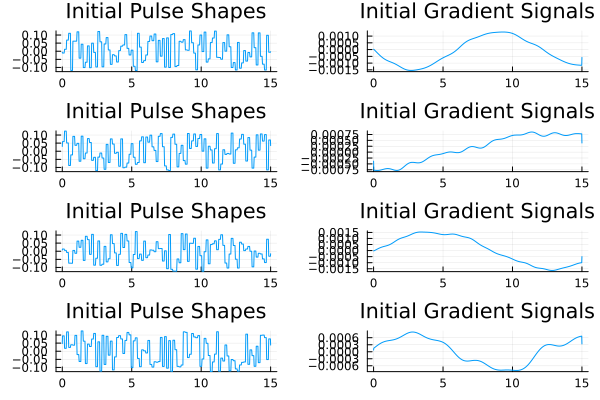

In [259]:
# PLOT PULSE SHAPES AND GRADIENT SIGNALS
pulses0 = constructpulses(x0)            # INITIAL PULSE OBJECTS
Ω0 = Matrix{Float64}(undef, r+1, n)     # CONSTRUCT Ω(t) FOR EACH QUBIT
for (q, pulse) in enumerate(pulses0)
    Ω0[:,q] .= map(t -> Pulses.amplitude(pulse, t), t_)
end
# # #
Ω_plots = plot(                         # PULSE SHAPE PLOT
    [plot(
        t_, Ω0[:,q]
    ) for q in 1:n]...,
    title = "Initial Pulse Shapes",
    ylim = [-ΔΩ, ΔΩ],
    legend = false,
    layout = (n,1),
)
# # #
Gradients.gradientsignal(ψ0, pulses0, device, O; gradient_kwargs...) # GRADIENT SIGNAL
∇Ω0 = copy(∇Ω)
∇Ω_plots = plot(                        # GRADIENT SIGNAL PLOT
    [plot(
        t_, ∇Ω0[:,q]
    ) for q in 1:n]...,
    title = "Initial Gradient Signals",
    legend = false,
    layout = (n,1),
)
# # #
plot(Ω_plots, ∇Ω_plots, layout=(1,2))   # COMBINE PLOTS INTO ONE

In [260]:
# RUN THE OPTIMIZATION
_, x = lbfgsb(f, g!, vec(x0), lb=vec(lbounds), ub=vec(ubounds),
    m=5,            # use last m iterations to inform new α, or something...
    factr=1e1,      # ENERGY CONVERGENCE CRITERION, in units of machine epsilon
    pgtol=1e-5,     # GRADIENT CONVERGENCE CRITERION (norm of projected gradient)
    iprint=50,      # PRINT EVERY FEW ITERATIONS, but it means something different for 99+
    maxfun=10000,   # How many times to call f before we give up?
    maxiter=10000,  # How many linesearches to run before we give up?
)
    #= `lbfgsb`s first return value (suppressed with `_`) is the energy `Ex`,
            but by calling `f(x)` manually at the end,
            I guarantee that the last values written to `ψ` are the final statevector. =#

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          404     M =            5

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.28838D+00    |proj g|=  6.18795D-02
  ys=-3.147E-03  -gs= 3.580E-02 BFGS update SKIPPED

At iterate   50    f= -7.69748D+00    |proj g|=  1.32119D-02

At iterate  100    f= -7.70122D+00    |proj g|=  6.44771D-03

At iterate  150    f= -7.70192D+00    |proj g|=  5.73874D-04

At iterate  200    f= -7.70196D+00    |proj g|=  3.75685D-04

At iterate  250    f= -7.70197D+00    |proj g|=  2.80860D-04
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate  300    f= -7.70198D+00    |proj g|=  1.73957D-03
  Positive dir derivative in projection 
  Using the backtracking step 
  Positive dir derivative in projection 
  Using the backtracking step 
  Positive dir derivative in projection 
  Using the backtracking step 
  Positive dir derivative in projection 
  Using the backtr

(-7.701994509556845, [0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174, 0.12566370614359174  …  -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, -0.12566370614359174, 24.547918769435235])

## FINAL RESULTS

In [261]:
# CONSTRUCT A BUNCH OF USEFUL VALUES FROM OPTIMIZATION RESULTS
pulses = constructpulses(x)         # CONSTRUCT FINAL PULSES
Gradients.gradientsignal(ψ0, pulses, device, O; gradient_kwargs...) # + GRADIENT SIGNAL
Ex = f(x)                           # CONSTRUCT FINAL ENERGY AND STATEVECTOR

leakage = 1 - real(ψ'*Π'*Π*ψ)       # CALCULATE LEAKAGE
E_normalized = Ex / (1 - leakage)   # CALCULATE RE-NORMALIZED ENERGY

Ω = Matrix{Float64}(undef, r+1, n)  # CONSTRUCT Ω(t) FOR EACH QUBIT
for (q, pulse) in enumerate(pulses)
    Ω[:,q] .= map(t -> Pulses.amplitude(pulse, t), t_)
end

In [262]:
# DISPLAY OPTIMAL FREQUENCIES
println("Unoptimized frequencies for each qubit:")
for (q, pulse) in enumerate(pulses0)
    println("\tQubit $q: ν=$(pulse.frequency)")
end
println("="^30)
println("Resonance frequencies for each qubit:")
for q in 1:n
    println("\tQubit $q: ω=$(device.ω[q])")
end
println("="^30)
println("Optimized frequencies for each qubit:")
for (q, pulse) in enumerate(pulses)
    println("\tQubit $q: ν=$(pulse.frequency)")
end

Unoptimized frequencies for each qubit:
	Qubit 1: ν=22.728727738461984
	Qubit 2: ν=26.20275686353819
	Qubit 3: ν=21.605726620688174
	Qubit 4: ν=24.651435480089656
Resonance frequencies for each qubit:
	Qubit 1: ω=23.24778563656447
	Qubit 2: ω=26.389378290154262
	Qubit 3: ω=21.991148575128552
	Qubit 4: ω=25.132741228718345
Optimized frequencies for each qubit:
	Qubit 1: ν=22.960346875876724
	Qubit 2: ν=26.252264574581147
	Qubit 3: ν=21.60279202713524
	Qubit 4: ν=24.547918769435235


In [263]:
# REPORT ENERGIES
println(" Unoptimized energy: $E0")
println("="^30)
println("            Leakage: $leakage")
println("Unnormalized energy: $Ex")
println("Renormalized energy: $E_normalized")

 Unoptimized energy: -7.288380418100105
            Leakage: 0.0
Unnormalized energy: -7.701994509556845
Renormalized energy: -7.701994509556845


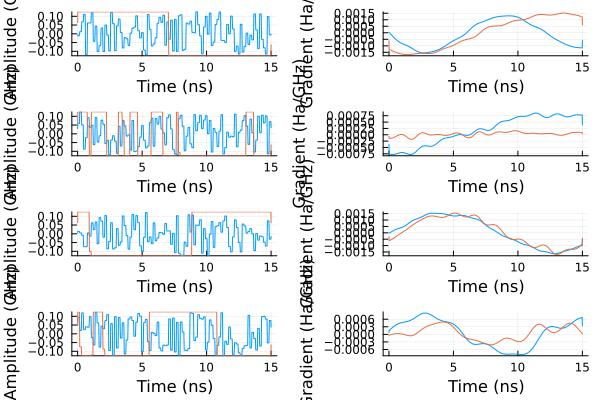

In [264]:
# PLOT PULSE SHAPES AND GRADIENT SIGNALS
Ω_plots = plot(
    [plot(
        t_, [Ω0[:,q], Ω[:,q]],
    ) for q in 1:n]...,
    ylabel="Amplitude (GHz)",
    xlabel="Time (ns)",
    ylim = [-ΔΩ, ΔΩ],
    legend = false,
    layout = (n,1),
)

∇Ω_plots = plot(
    [plot(
        t_, [∇Ω0[:,q], ∇Ω[:,q]]
    ) for q in 1:n]...,
    ylabel="Gradient (Ha/GHz)",
    xlabel="Time (ns)",
    legend = false,
    layout = (n,1),
)

plot(Ω_plots, ∇Ω_plots, layout=(1,2))


In [265]:
# CONSTRUCT A COUPLE USEFUL VALUES FROM SOLVING FCI MATRIX (if tractable)
Λ, U = eigen(O)
E_FCI = Λ[1]
ψ_FCI = U[:,1]

println("                FCI energy: $E_FCI")
println("  Unoptimized energy error:  $(E0-E_FCI)")
println(" Hartree Fock energy error:  $(E_HF-E_FCI)")
println()
println("    Optimized energy error:  $(E_normalized-E_FCI)")
println("Optimized state infidelity:  $(Utils.infidelity(ψ,ψ_FCI))")
println()
println("       Energy error wrt HF:  $((E_normalized-E_FCI)/(E_HF-E_FCI))")

                FCI energy: -7.7983634306847245
  Unoptimized energy error:  0.5099830125846196
 Hartree Fock energy error:  0.49639852068472834

    Optimized energy error:  0.09636892112787976
Optimized state infidelity:  0.517361015124662

       Energy error wrt HF:  0.19413619725326578
